## Image classification using XGBoost, without sentence embeddings

In [1]:
# importing necessary libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf

from PIL import Image
import cv2

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import xgboost

from PIL import Image as im 

2024-10-20 12:45:05.499880: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 12:45:05.541029: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 12:45:06.201151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# reading the metadata with labels and file names
df = pd.read_pickle('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_128embeddings.pkl')

In [4]:
# head of metadata; for this exercise only the mp3_path and tags will be used
df.head()

,mp3_path,tags,caption_writing,caption_embedding
clip_id,,,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...,"[0.008151676, 0.07329603, 0.99982566, 0.999194..."
6,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...,"[0.00060438353, 0.008377695, 0.9999999, 0.9999..."
10,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...,"[0.01728542, 0.09863398, 0.9972607, 0.99550676..."
11,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...,"[0.71541905, 0.26625627, 0.321584, 0.12895806,..."
14,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...,"[0.61524045, 0.066562384, 0.57550013, 0.125865..."


In [5]:
# the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

# the ordered list of all the filenames in the metadata
audio_names_list = df.mp3_path.to_list()

In [6]:
# fixing the image size for all the melspectrograms
IMG_SIZE = (128, 1255)

In [7]:
# function to add gaussian noise to the melspecs
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [ ]:
#TODO: delete this cell later
# do not execute this cell
data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
    filename_npy = str(filename[:-4]) + '.npy'
    file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
    img = np.load(file_path)
    data.append(add_gauss_noise(img))

    # To ensure that the files are getting loaded in the correct order
    if i < 10 :
        print(filename)
    i = i+1

data = np.array(data)

In [11]:
import librosa
input_folder = "/home/mendu/Thesis/data/magnatagatune/audio"

# list of all the mp3 files in the input_folder 
audio_list = os.listdir(input_folder)
audio_list.sort()



In [26]:
filename = audio_list[2]
audio_path = os.path.join(input_folder, filename)
y, sr = librosa.load(audio_path)

# compute the mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

# convert to decibel scale
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

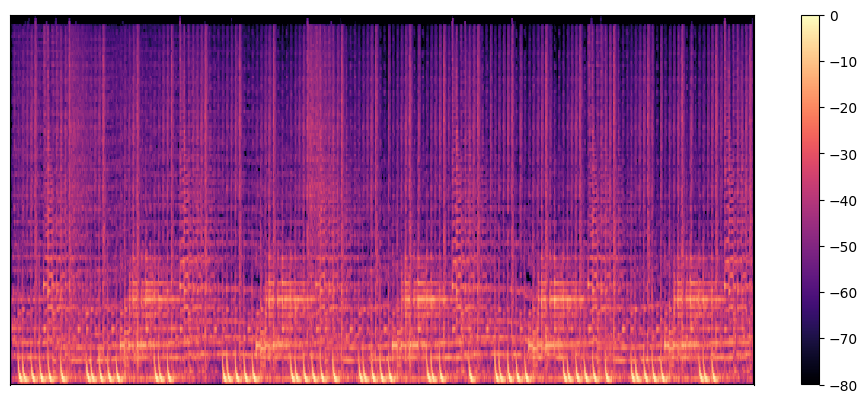

In [27]:
plt.figure().set_figwidth(12)
librosa.display.specshow(mel_spectrogram_db, sr=sr, fmax=8000)
plt.colorbar()

In [28]:
np.save('/home/mendu/Thesis/delete_later.npy', mel_spectrogram_db)

In [30]:
np.load('/home/mendu/Thesis/delete_later.npy').shape

(128, 1255)

In [8]:
temp = str(audio_names_list[0][:-4] + '.npy')
path = os.path.join(folder_path_mel, temp)
img = np.load(path)

In [10]:
img.shape

(128, 1255)

In [6]:
temp = str(audio_names_list[0][:-4] + '.npy')
path = os.path.join(folder_path_mel, temp)
img = np.load(path)
# img = cv2.imread(path, cv2.IMREAD_COLOR)       
# img = cv2.resize(img, IMG_SIZE)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
'''you dont need to do the top three lines if you just load and append that is enough'''

In [7]:
# data = np.load('data/magnatagatune/saved_df_data/data_array.npy')
data = np.load('/home/mendu/Thesis/data/magnatagatune/saved_df_data/data_array.npy')

In [8]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255)

In [9]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split into training (0.8) and remaining set (0.2)
train_images, X_rem_spec, train_labels, y_rem = train_test_split(data, df['tags'], test_size=0.2, random_state=42)

# Split the remaining set into validation (0.1) and test (0.1)
val_images, test_images, val_labels, test_labels = train_test_split(X_rem_spec, y_rem, test_size=0.5, random_state=42)

In [10]:
le = preprocessing.LabelEncoder()

le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

le.fit(val_labels)
val_labels_encoded = le.transform(val_labels)

le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)

In [14]:
IMG_SHAPE = IMG_SIZE + (1,)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

ValueError: The input must have 3 channels; Received `input_shape=(128, 1255, 1)`

In [12]:
base_model.trainable = False

base_model.summary()

NameError: name 'base_model' is not defined

In [13]:
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del(train_images)

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del(val_images)

NameError: name 'base_model' is not defined